### Motif Recognition in Subsequence Time Series Data

In [307]:
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import spatial

In [308]:
# Set some constants. We use them to populate our training set, but our model has no knowledge of these values

DATA_TIME_LENGTH = 3600 # this is the length of time over which we populate the dataset. Arbitrarily set to 1 hour

MOTIFS = 10           #number of motifs used
MAX_INSTANCES = 10    #maximum number of times each motif can appear in the data set
MIN_INSTANCES = 1     #minumum number of times each motif can appear in the data set
EVENTS = 10           #number of individual events that can be values in a motif. 
                    #Note that the numbers here are not ordered and imply no hierarchy. The distance metric does not
                    # incorporate the distance between these numbers. They just represent different values

MIN_EVENTS_PER_MOTIF = 2
MAX_EVENTS_PER_MOTIF = 5
MAX_MOTIF_LEN = 30 #maximum time for a pattern to last in seconds

# These constants are the bounds on how many times each motif appears in the full datat set
MIN_MOTIF_INSTANCES = 5
MAX_MOTIF_INSTANCES = 10

# How many data points of noise to use.
# The actual ratio of signal to noise depends on this value, DATA_TIME_LENGTH,
# and the MIN_INSTANCES and MAX_INSTANCES values
NOISE_EVENTS = 100

In [309]:
# Generate the motifs with enough randomness to make our model robust. 
# Pandas prefers a dict of {(tuples of multilevel indices):{dict of column names:values}}

In [310]:
import colorsys # We use this to color the motifs in the visuals below. 
                # since matplotlib doesn't use hsv, but hue is a useful 1D representation 
                # of the color wheel, we use colorsys to convert from hsv to rgb 

In [311]:
motifs = []

for i in range(1,MOTIFS + 1):
    temp_d = {}
    for j in range(random.randint(MIN_EVENTS_PER_MOTIF,MAX_EVENTS_PER_MOTIF)):
        rand_k=random.randint(1, MAX_MOTIF_LEN)
        temp_d[j]={'motif_id':i,
                'td_from_motif_start(s)':rand_k, # use rand_k as index also because it lets us sort these chronologically easily
                'event_type':random.randint(1, EVENTS),
                'plot_color':colorsys.hsv_to_rgb(i/MOTIFS,1,1)}
        
    motifs.append(pd.DataFrame(temp_d).T.sort_values(by='td_from_motif_start(s)').reset_index(drop=True))

<B>Lets look at what the motifs look like as scatter plots</B>

In [312]:
import colorsys

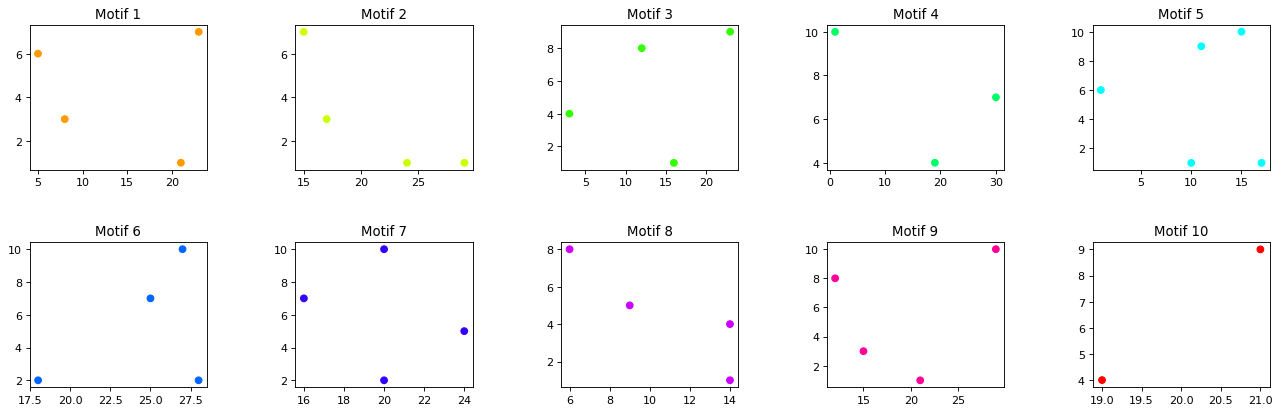

In [324]:
figure(num=None, figsize=(20,6), dpi=80)
plt.subplots_adjust(wspace = 0.5,hspace = 0.5)
plt.ylim(bottom=1, top=EVENTS)
for motif in motifs:
    plt.subplot(2,5,motif.loc[0,'motif_id'])
    plt.scatter(motif['td_from_motif_start(s)'],motif['event_type'], c=motif['plot_color'])
    plt.title('Motif '+str(motif.loc[0,'motif_id']))

<B>Populate a dataset randomly with instances of the motifs above, then add noise.</B>

In [325]:
test_data = pd.DataFrame({'time':[],'event':[]}) # empty dataframe which we populate with our motif instances, and then add noise   # length of our data-set in seconds
temp_dt = 0                                 # stores the random start time of each motif

for motif in motifs:
    for j in range(random.randint(MIN_MOTIF_INSTANCES,MAX_MOTIF_INSTANCES)):
        temp_dt = random.randint(MAX_MOTIF_LEN,DATA_TIME_LENGTH) - MAX_MOTIF_LEN
        temp_df = motif
        temp_df['time'] = temp_df['td_from_motif_start(s)']+temp_dt
        temp_df = temp_df[['time','event_type','motif_id','plot_color']].rename(columns={'event_type':'event'})
        
        test_data = pd.concat([test_data, temp_df])

In [326]:
# A motif_id of 0 indicates that a point is noise.
# A positive motif id indicates that a data point belongs to an instance of that motif

noise = pd.DataFrame({'event':np.random.randint(0,EVENTS,NOISE_EVENTS),
                     'motif_id':np.zeros(NOISE_EVENTS),
                     'plot_color':[(0,0,0) for i in range(NOISE_EVENTS)],
                     'time':np.random.randint(0,DATA_TIME_LENGTH,NOISE_EVENTS)})

<B>Combine data with noise and sort on time</B>

In [327]:
test_data = pd.concat([test_data, noise])
test_data = test_data.sort_values('time')
test_data.reset_index(drop=True,inplace=True)

Double click the visual below to expand


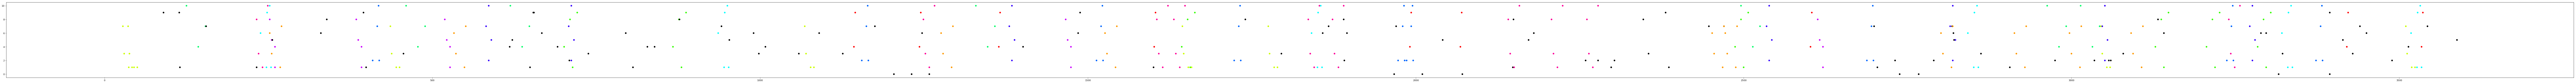

In [328]:
figure(num=None, figsize=(200,6), dpi=80)
plt.scatter(test_data['time'], test_data['event'], c=test_data['plot_color'])

print('Double click the visual below to expand')

<B>Now that we have a test data set, lets define a 'similarity' function that will be the cornerstone of our motif-finding algorithm</B>

In [329]:
def smoothed_cosine_similarity(v1, v2, s=1, display=False):
    
    # Takes 2 numpy arrays.
    # Apply a smoothing function to both which uses the rectangular pulse of length s as a smoothing factor.
    # Return the cosine of the angle between the smoothed arrays (cosine similarity) as a normalized similarity measure
    
    # Note the degenerate case where either v1=0 or v2=0 in which we return 0

    if v1.sum()==0 or v2.sum()==0:
        return 0
    
    # If we reach this point, neither vector is the 0 vector
    
    # smooth
    v_smooth = np.full(s, 1 / s)
    c1 = np.convolve(v1, v_smooth)
    c2 = np.convolve(v2, v_smooth)
    
    # show normalized sequences 
    if display:
        figure(num=None, figsize=(20,6), dpi=80)
        
        #First sequence
        
        plt.subplot(2,2,1)
        plt.plot(v1)
        plt.gca().set_ylim([0,1.25])
        plt.title('Original Sequence 1')

        plt.subplot(2,2,2)
        plt.plot(c1)
        axes = plt.gca()
        axes.set_ylim([0,1])
        plt.title('Smoothed Sequence 1')
        
        #Second sequence
        
        plt.subplot(2,2,3)
        plt.plot(v2)
        plt.gca().set_ylim([0,1.25])
        plt.title('Original Sequence 2')

        plt.subplot(2,2,4)
        plt.plot(c2)
        axes = plt.gca()
        axes.set_ylim([0,1])
        plt.title('Smoothed Sequence 2')
    
    # get magnitude of difference
    similarity = np.dot(c1,c2)/(np.linalg.norm(c1)*np.linalg.norm(c2))
    if display:
        print('Smoothed Cosine Similarity of '+str(similarity))
    return(similarity)

<B>To get a sense of what this similarity funciton does, lets look at an example. One of the first pair of sequences has a spike in the middle, yielding a similarity value of ~0.71</B>

Smoothed Cosine Similarity of 0.7123956116565481


0.7123956116565481

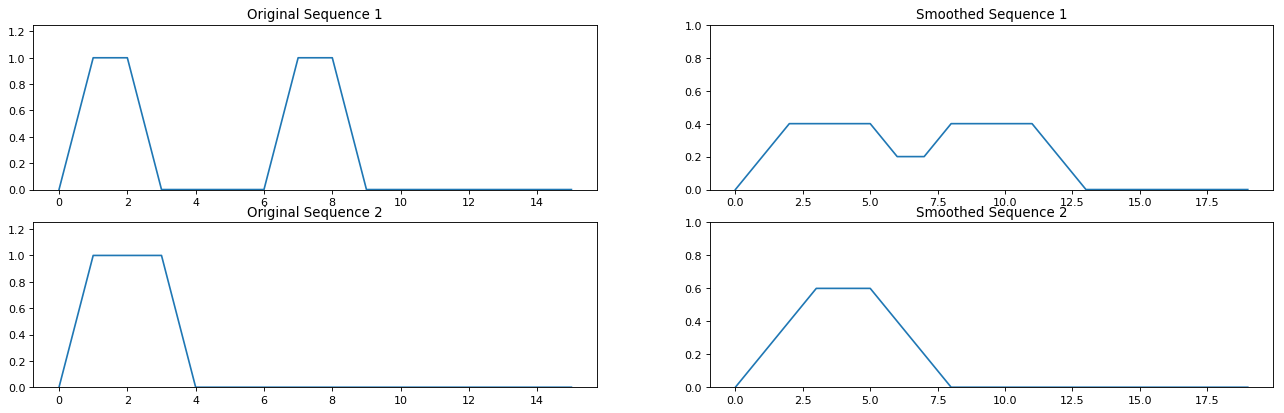

In [330]:
a=np.array([0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0])
b=np.array([0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0])

smoothed_cosine_similarity(a,b,5,display=True)

<B>Now notice when we add a spike to the seocond sequence, relatively close to where it appears in the first sequence, the similarity measure increases to ~0.85</B>

Smoothed Cosine Similarity of 0.8539864924534398


0.8539864924534398

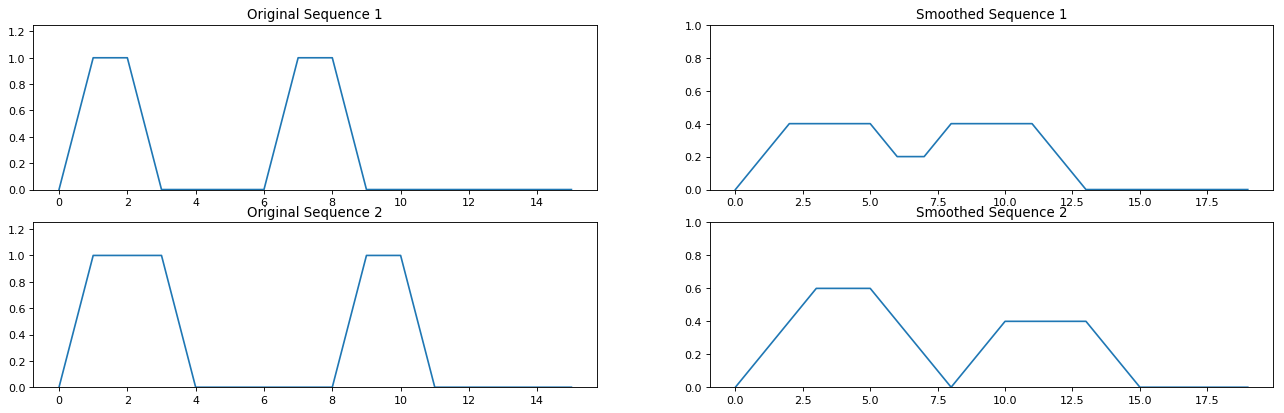

In [331]:
a=np.array([0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0])
b=np.array([0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0])

smoothed_cosine_similarity(a,b,5,display=True)

<b>To make our data easier to work with, lets transform the dataframe of events into a binary 2d array with length equal 
to the total time observed, and width equal to the number of distinct event types.</b>

In [333]:
test_data = test_data.set_index('time').join(test_data.groupby('time').apply(lambda x:pd.Series([1 if i in x['event'].values else 0 for i in range(0,EVENTS)])))
test_data = test_data.loc[~test_data.index.duplicated(keep='first')]

In [336]:
test_data = test_data.reindex(pd.RangeIndex(DATA_TIME_LENGTH),fill_value=0)
test_data.drop(columns=['event','motif_id','plot_color'], inplace=True)

<b> Lets look at a slice of our test data to get a sense of what it looks like. </b>

In [355]:
test_data.iloc[40:50]

,0,1,2,3,4,5,6,7,8,9,sum
40,0,0,0,0,0,0,0,0,0,0,0.0
41,0,0,0,0,0,0,0,0,0,0,0.0
42,0,1,0,0,0,0,0,0,0,0,1.0
43,0,0,0,0,0,0,0,0,0,0,0.0
44,0,0,0,0,0,0,0,0,0,0,0.0
45,0,1,0,0,0,0,0,0,0,0,1.0
46,0,0,0,0,0,0,0,0,0,0,0.0
47,0,0,0,0,0,0,0,0,0,0,0.0
48,0,0,0,0,0,0,0,0,0,0,0.0
49,0,0,0,0,0,0,0,0,0,0,0.0


<B> The data is now formatted as a sparsely populated matrix where each row is a binary sequence indicating which events, if any
 occurred at each point in time. We are now ready to search this data for motifs.</B>

In [352]:
# Start by taking the sum across the rows to see if an event occurred

test_data['sum']=test_data.apply(lambda x:x.drop('sum').sum(),axis=1)